# Network Simulation Evaluation

First import all needed libraries and set global constants and configurations:

In [1]:
import glob
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cm = 1/2.54
linewidth = 14.6979 * cm # line width in TuDa template
sns.set_theme(context='paper', style='whitegrid', palette='deep', rc={'figure.figsize':(linewidth, 10*cm)})

We define two functions to read in the `clab` output:

- `get_pidstat_df` reads in pidstat output and adds a duration column as well as a node column to identify the reading
- `get_network_df` reads in network traffic logs and adds a duration column as well as a node column to identify the reading. Also, some units are transformed to make the stats more readable

In [2]:
correct_log_header = "Time          UID       PID    %usr %system  %guest   %wait    %CPU   CPU  minflt/s  majflt/s     VSZ     RSS   %MEM   kB_rd/s   kB_wr/s kB_ccwr/s iodelay  Command\n"
del_col = ["Command", "PID", "%system","%guest", "%wait"]

def get_pidstat_df(scen_dir, nodes):
    pidstat_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"net-sim/eval/{scen_dir}/results-*/n*/pidstat-{node_name}.csv.log"):

            # change header since Pandas will not be able to parse it correctly
            with open(filepath, "r") as fh:
                lines = fh.readlines()
            lines[0] = correct_log_header
            # store it in a temporary file object so we don't need to
            # modify the (potentially protected) original file
            data = io.StringIO("".join(lines))

            df = pd.read_fwf(data)
            df["duration"] = df["Time"] - df["Time"][0]
            df["node"] = node_name
            # for c in del_col:
            #        del df[c]
            pidstat_df = pd.concat([pidstat_df, df], ignore_index=True)
            
    return pidstat_df

In [3]:
csv_header = ["timestamp", "iface_name", "bytes_out/s", "bytes_in/s", "bytes_total/s", "bytes_in", "bytes_out", "packets_out/s",
    "packets_in/s", "packets_total/s", "packets_in", "packets_out", "errors_out/s", "errors_in/s", "errors_in", "errors_out"]

def get_network_df(scen_dir, nodes):
    net_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"net-sim/eval/{scen_dir}/results-*/n*/net-{node_name}.log"):
            df = pd.read_csv(filepath, sep=";", names=csv_header)
            df["duration"] = (df["timestamp"] - df["timestamp"][0]).round(0).astype(int)
            df["node"] = node_name
            df["kb_in/s"] = df["bytes_in/s"] / 1000
            df["kb_out/s"] = df["bytes_out/s"] / 1000
            df["kb_total/s"] = df["bytes_total/s"] / 1000
            
            net_df = pd.concat([net_df, df], ignore_index=True)
    
    return net_df

### Szenario `1k`

In this scenario, three nodes start off with no connection between them. `n1` is pre-loaded with $1000$ articles that are in the DB of the *moNNT.py Server* and in the store of the *dtnd*.

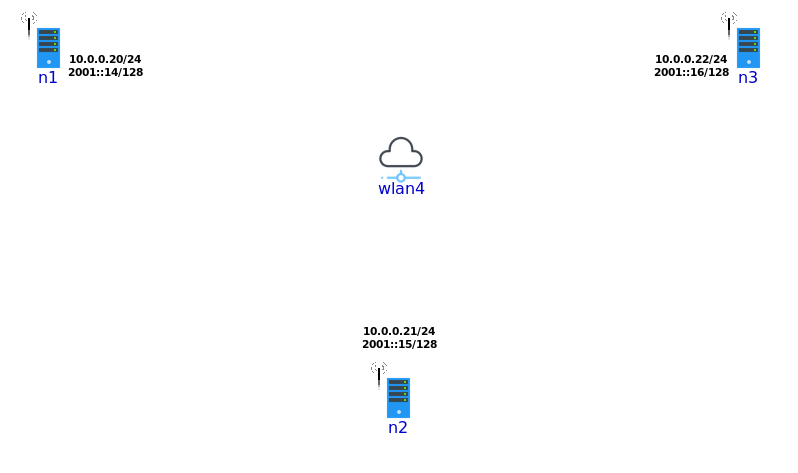

Then the simulation runs through the following steps:

1. Wait 10 seconds
2. `n2` moves into proximity of `n1` -- after a short period both *dtnd* instances will discover eachother and exchange previously unknown bundles, which will then be pushed to the respective *moNNT.py* instance.
3. Wait 10 seconds
4. `n2` moves into proximity of `n3` -- analog to step 2.
5. Wait 10 seconds

In [4]:
nodes_1k = ["n1", "n2", "n3"]
scen_dir_1k = "1k"

#### CPU utilization, memory usage, and storage writes

In [5]:
pidstat_1k_df = get_pidstat_df(scen_dir=scen_dir_1k, nodes=nodes_1k)

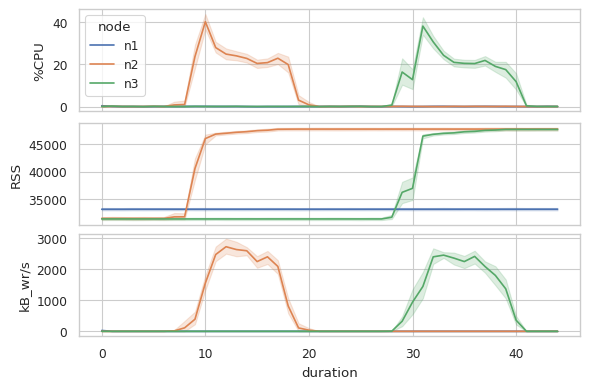

In [6]:
stats_1k = ["%CPU", "RSS", "kB_wr/s"]
cols_1k, rows_1k = [1, len(stats_1k)]

fig_1k, ax_1k = plt.subplots(rows_1k, cols_1k, figsize=(linewidth, rows_1k*3.2*cm), constrained_layout=True, sharex=True)
for i, g in enumerate(stats_1k):
    sns.lineplot(data=pidstat_1k_df, x="duration", y=g, hue="node", ax=ax_1k[i])
    if i > 0:
        ax_1k[i].get_legend().remove()

# save legend for later on
global_handles, global_labels = ax_1k[0].get_legend_handles_labels()

In [ ]:
fig_1k.savefig("ch6_1k_cpu_str.pdf")

#### Network transfers

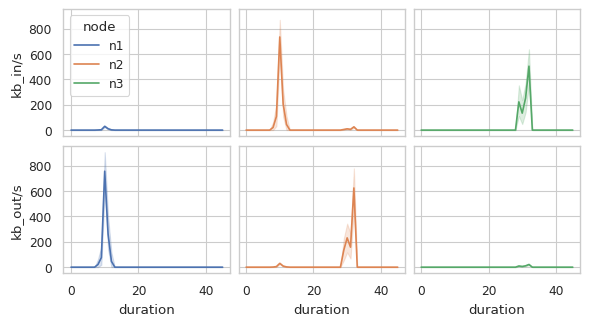

In [7]:
net_1k_df = get_network_df(scen_dir=scen_dir_1k, nodes=nodes_1k)
y_cols_1k = ["kb_in/s", "kb_out/s"]  # , "bytes_total/s"]

fig_net_1k, ax_net_1k = plt.subplots(2, 3, figsize=(linewidth, 2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, y_col in enumerate(y_cols_1k):
    for j, n in enumerate(nodes_1k):
        sns.lineplot(
            data=net_1k_df[(net_1k_df["iface_name"] == "total") & (net_1k_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j], ax=ax_net_1k[i][j])
_ = ax_net_1k[0][0].legend(title="node", handles=global_handles, labels=global_labels, loc='upper left')

In [ ]:
fig_net_1k.savefig("ch6_1k_net.pdf")

#### Reliability

In order to call the implementation **reliable**, all messages that were first stored on `n1` must be transferred
to `n3` through `n2`. We will count received bundles on nodes `n2` and `n3` to ensure reliable transfer.

The following code searches all produced `dtnd` logs for the phrase `Received new bundle: dtn://n1`, which should occur
exactly $1000$ times on each node on each run. In this case, the code will output `True`:

In [8]:
counts_1k = []
for node_name in nodes_1k[1:]:
    for filepath in glob.glob(f"net-sim/eval/1k/results-*/n*/nohup.dtnd_{node_name}.log"):
        with open(filepath, "r") as fh:
            counts_1k.append(fh.read().count("Received new bundle: dtn://n1"))
all([c == 1000 for c in counts_1k])

True

### Szenario `always_on`

In this scenario, two nodes are within range of eachother continuously. On each node, news clients send articles every 0.3 seconds after an initial delay of 2 seconds. These are first processed by the local moNNT.py and dtnd instances before being sent to the other node, where they are also processed and integrated into the database, respectively store.

In [9]:
nodes_ao = ["n1", "n2"]
scen_dir_ao = "always_on"

#### CPU utilization, memory usage, and storage writes

In [10]:
pidstat_ao_df = get_pidstat_df(scen_dir=scen_dir_ao, nodes=nodes_ao)

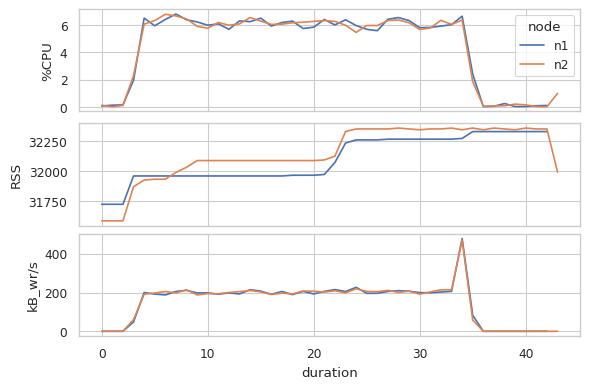

In [12]:
stats_ao = ["%CPU", "RSS", "kB_wr/s"]
cols_ao, rows_ao = [1, len(stats_ao)]

fig_ao, ax_ao = plt.subplots(rows_ao, cols_ao, figsize=(linewidth, rows_ao*3.2*cm), constrained_layout=True, sharex=True)
for i, g in enumerate(stats_ao):
    sns.lineplot(data=pidstat_ao_df, x="duration", y=g, hue="node", ax=ax_ao[i], errorbar=None)
    if i > 0:
        ax_ao[i].get_legend().remove()

# save legend for later on
global_handles, global_labels = ax_ao[0].get_legend_handles_labels()

In [13]:
fig_ao.savefig("ch6_always_on_cpu_str.pdf")

#### Network transfers

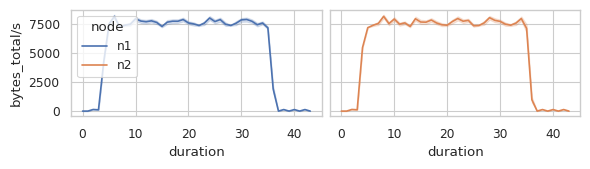

In [19]:
net_ao_df = get_network_df(scen_dir=scen_dir_ao, nodes=nodes_ao)
# y_cols = ["kb_in/s", "kb_out/s"]  # , 
y_cols_net_ao = "bytes_total/s"

fig_net_ao, ax_net_ao = plt.subplots(1, len(nodes_ao), figsize=(linewidth, 4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, n in enumerate(nodes_ao):
    sns.lineplot(
        data=net_ao_df[(net_ao_df["iface_name"] == "total") & (net_ao_df["node"] == n)],
        x="duration", y=y_cols_net_ao, color=sns.color_palette()[i], ax=ax_net_ao[i])
_ = ax_net_ao[0].legend(title="node", handles=global_handles, labels=global_labels, loc='upper left')

In [29]:
fig_net_ao.savefig("ch6_always_on_net.pdf")

### Szenario `busynode`

In [20]:
nodes_bn = ["n1", "n2"]
scen_dir_bn_nozip = "busynode_nozip"
scen_dir_bn_zip = "busynode_zip"
pidstat_bn_nozip_df = get_pidstat_df(scen_dir=scen_dir_bn_nozip, nodes=nodes_bn)
pidstat_bn_zip_df = get_pidstat_df(scen_dir=scen_dir_bn_zip, nodes=nodes_bn)

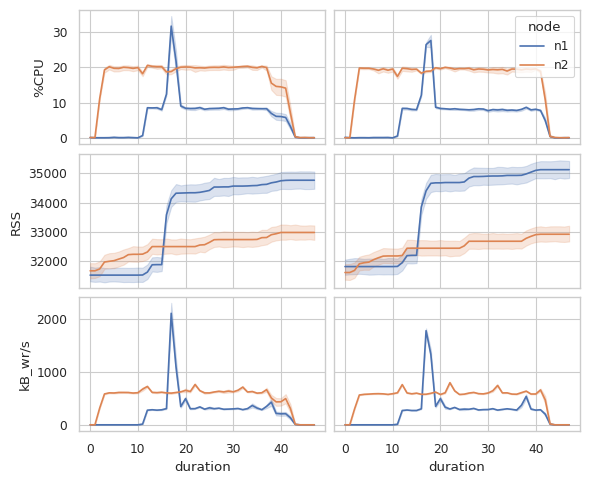

In [21]:
cols_bn, rows_bn = [2, 3]

fig_bn, ax_bn = plt.subplots(rows_bn, cols_bn, figsize=(linewidth, rows_bn*4*cm), constrained_layout=True, sharex=True, sharey="row")
for i, g in enumerate(["%CPU", "RSS", "kB_wr/s"]):
    sns.lineplot(data=pidstat_bn_nozip_df, x="duration", y=g, hue="node", ax=ax_bn[i][0], legend=False)
    sns.lineplot(data=pidstat_bn_zip_df, x="duration", y=g, hue="node", ax=ax_bn[i][1])
    if i > 0:
        ax_bn[i][1].get_legend().remove()

In [ ]:
fig_bn.savefig("ch6_busynode_cpu_str.pdf")

#### Network transfers

NameError: name 'current_handles' is not defined

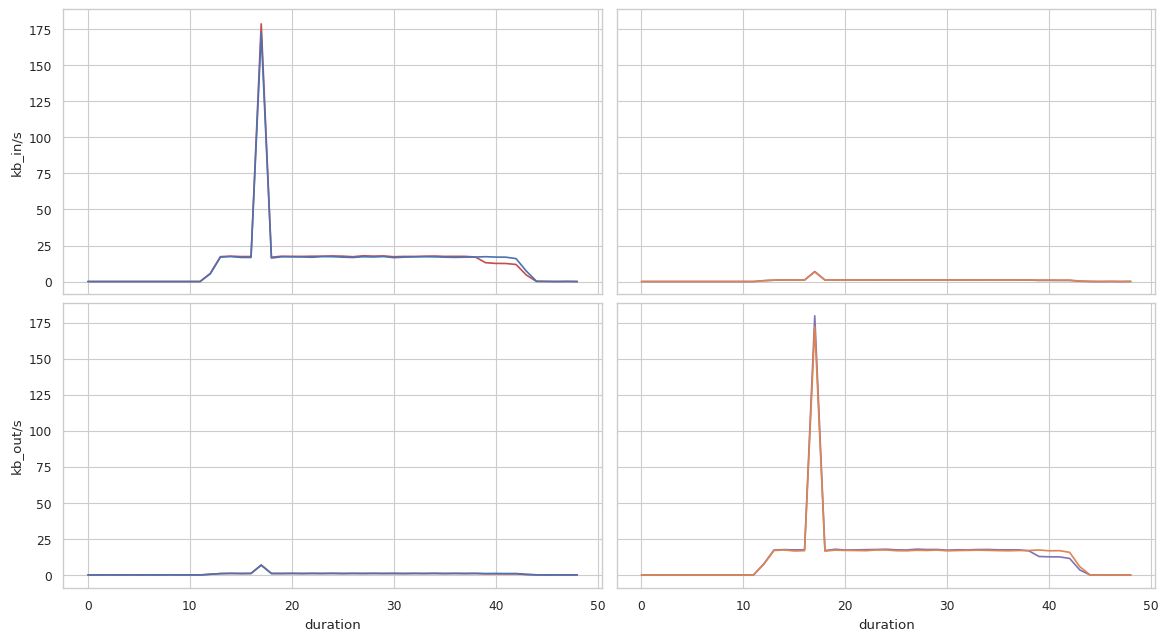

In [28]:
net_bn_nozip_df = get_network_df(scen_dir=scen_dir_bn_nozip, nodes=nodes_bn)
net_bn_zip_df = get_network_df(scen_dir=scen_dir_bn_zip, nodes=nodes_bn)
y_cols_net_bn = ["kb_in/s", "kb_out/s"]  # , "bytes_total/s"]

fig_net_bn, ax_net_bn = plt.subplots(2, len(nodes_bn), figsize=(2*linewidth, 2*2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, y_col in enumerate(y_cols_net_bn):
    for j, n in enumerate(nodes_bn):
        sns.lineplot(
            data=net_bn_nozip_df[(net_bn_nozip_df["iface_name"] == "total") & (net_bn_nozip_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j+3], ax=ax_net_bn[i][j], errorbar=None)
        sns.lineplot(
            data=net_bn_zip_df[(net_bn_zip_df["iface_name"] == "total") & (net_bn_zip_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j], ax=ax_net_bn[i][j], errorbar=None)

# _ = ax_net_bn[0][0].legend(current_handles, ["node", "n1", "n2", "n3"], loc="upper left")